# Humidity vs Electricity Demand

This notebook explores whether **humidity (%)** has a measurable relationship with
**electricity demand** across Australian states (NSW, VIC, QLD, SA, TAS).

**Focus (portfolio scope):**
- Humidity ↔ Demand relationship
- Differences across states
- Seasonal patterns (Summer/Autumn/Winter/Spring)
- Simple regression (optional)

**Inputs:** Cleaned state files or a combined master file produced by the processing notebook.

## 1. Understanding the Data

This dataset combines **electricity demand** data from the Australian Energy Market Operator (AEMO) with **humidity observations** from the Bureau of Meteorology (BOM).

For this project, we are specifically focused on:

- `Total Demand` — half-hourly electricity demand (MW)  
- `Humidity (%)` — relative humidity measured at BOM weather stations  
- `Datetime` — timestamp used to align demand and weather data  
- `State` — Australian state (NSW, VIC, QLD, SA, TAS)

Additional time-based features (such as **month** and **season**) are extracted from the `Datetime` column to investigate whether the relationship between humidity and electricity demand varies throughout the year.


# 2. Importing Libraries and Setting Up the Environment

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 3. Load Data

In [49]:
data = pd.read_csv("data/processed/master_data.csv")
print("Shape:", data.shape)
print("Columns:", list(data.columns))

Shape: (1534013, 6)
Columns: ['State', 'Datetime', 'Total Demand', 'RRP', 'Humidity (%)', 'Temperature']


## 4. Basic cleaning
Drop rows where humidity is missing.

In [16]:
print("Missing Humidity (%) before:", data["Humidity (%)"].isna().sum())
data = data.dropna(subset=["Humidity (%)"])
print("Missing Humidity (%) after:", data["Humidity (%)"].isna().sum())

# Make sure key columns are numeric / datetime
data["Datetime"] = pd.to_datetime(data["Datetime"], errors="coerce")
data["Humidity (%)"] = pd.to_numeric(data["Humidity (%)"], errors="coerce")
data["Total Demand"] = pd.to_numeric(data["Total Demand"], errors="coerce")

# Drop rows where datetime/demand/humidity couldn't be parsed
data = data.dropna(subset=["Datetime", "Humidity (%)", "Total Demand"])

# Keep humidity in realistic range
data = data[(data["Humidity (%)"] >= 0) & (data["Humidity (%)"] <= 100)]

print("Final shape after cleaning:", data.shape)

Missing Humidity (%) before: 1043
Missing Humidity (%) after: 0
Final shape after cleaning: (1532919, 5)


## 5. Exploratory Data Analysis

### Distribution of Humidity Overall

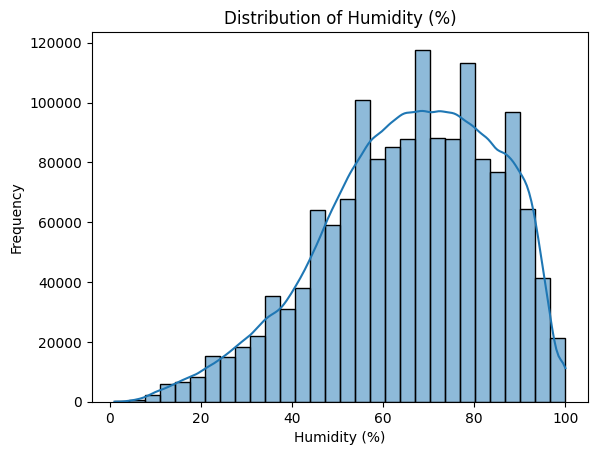

In [21]:
sns.histplot(data["Humidity (%)"], bins=30, kde=True)
plt.title("Distribution of Humidity (%)")
plt.xlabel("Humidity (%)")
plt.ylabel("Frequency")
plt.show()

### Distribution of humidity by state

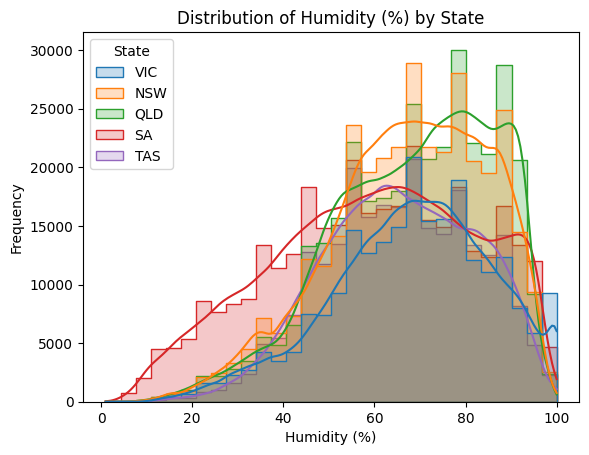

In [22]:
sns.histplot(data=data, x="Humidity (%)", hue="State", bins=30, kde=True, element="step")
plt.title("Distribution of Humidity (%) by State")
plt.xlabel("Humidity (%)")
plt.ylabel("Frequency")
plt.show()

### Demand vs Humidity (Scatter, By State)

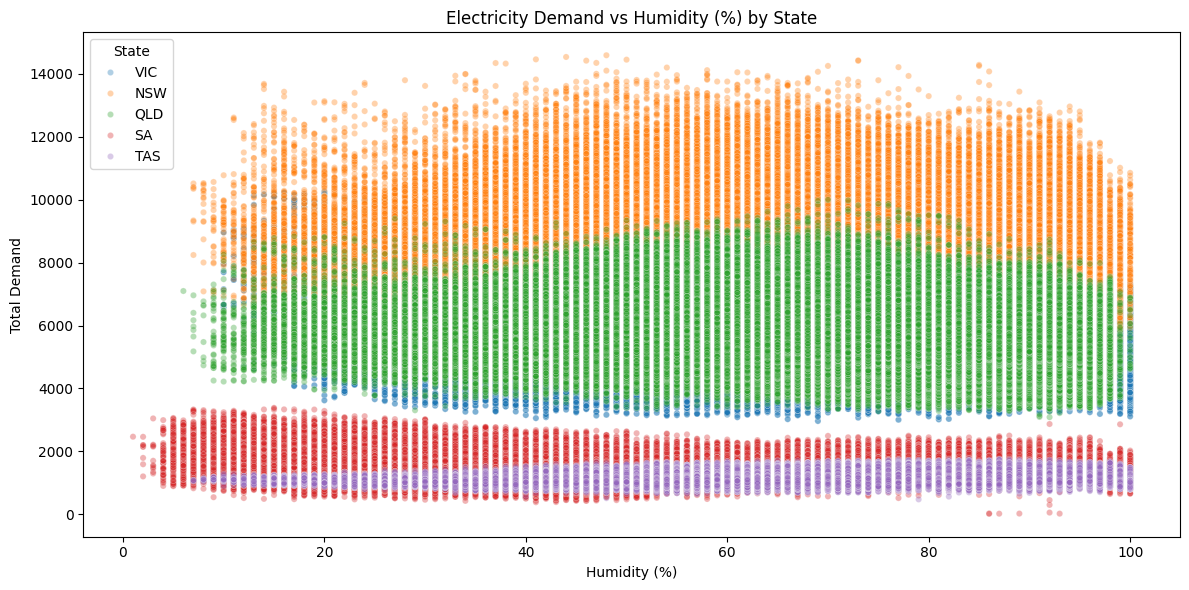

In [25]:
plt.figure(figsize=(12,6))
sns.scatterplot(
    data=data,
    x="Humidity (%)",
    y="Total Demand",
    hue="State",
    alpha=0.35,
    s=20
)
plt.title("Electricity Demand vs Humidity (%) by State")
plt.xlabel("Humidity (%)")
plt.ylabel("Total Demand")
plt.legend(title="State", loc="upper left")
plt.tight_layout()
plt.show()

/var/folders/0d/qf_dfhwn3vjd4fvry35670240000gn/T/ipykernel_19898/1284502288.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=min(8000, len(g)), random_state=42))


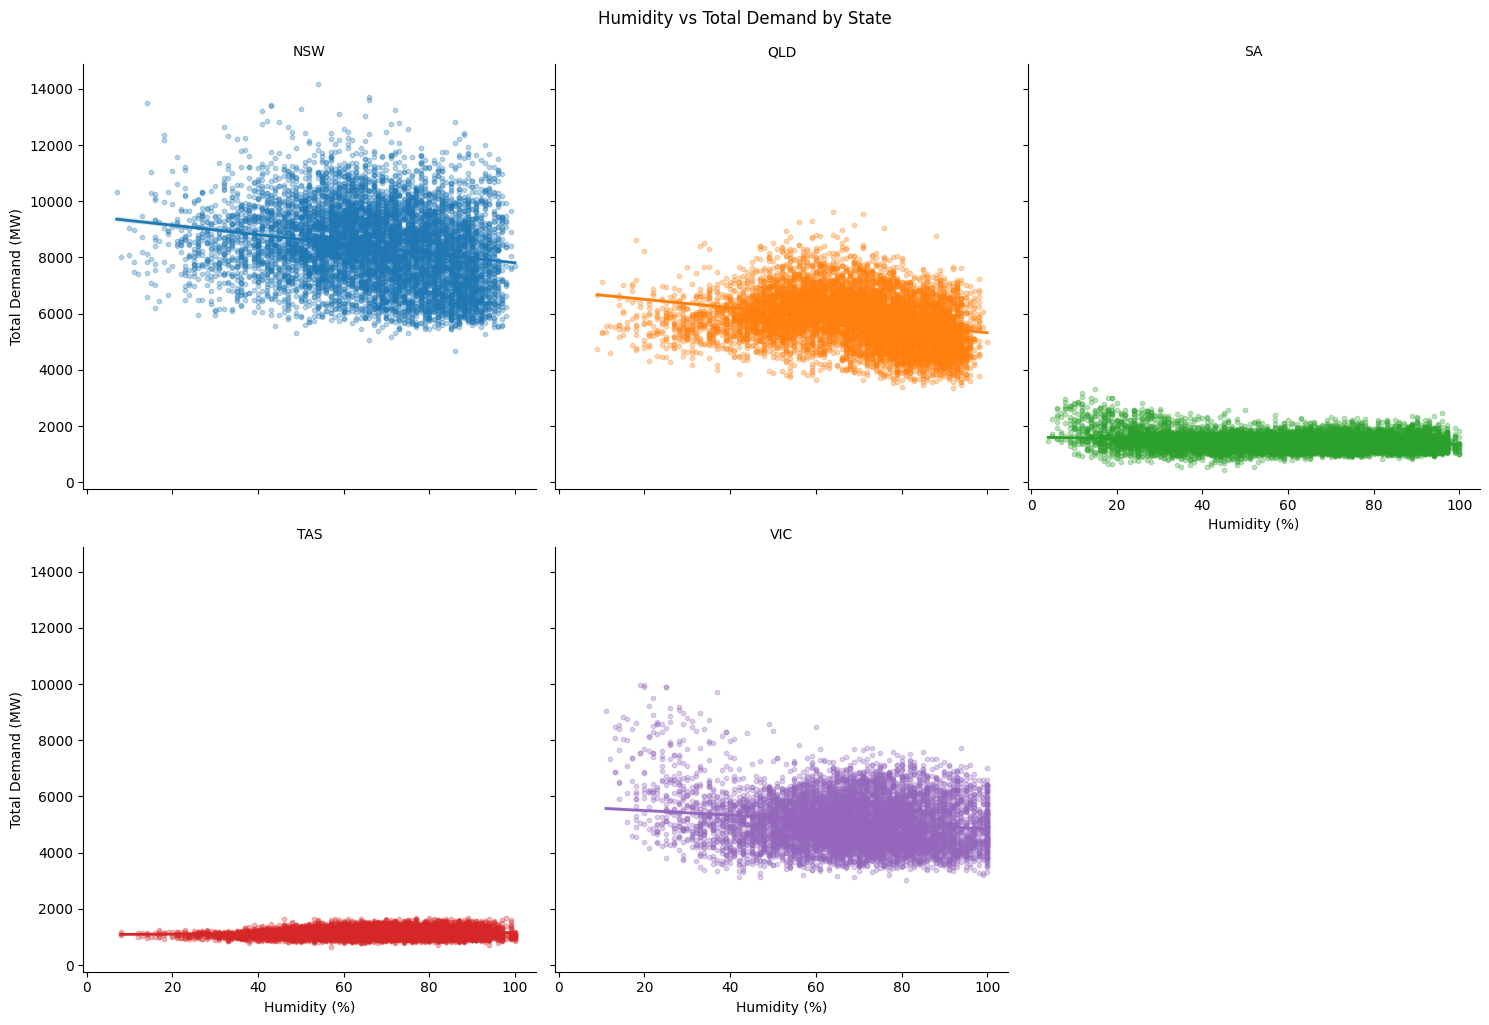

In [40]:
# Downsample data, random sample up to 8000 rows per state
df_sample = (data.groupby("State", group_keys=False, observed=True)
        .apply(lambda g: g.sample(n=min(8000, len(g)), random_state=42))
        .reset_index(drop=True)
)


g = sns.lmplot(
    data=df_sample,
    x="Humidity (%)", y="Total Demand",
    hue="State",
    col="State", col_wrap=3,
    scatter_kws={"s": 10, "alpha": 0.3},
    line_kws={"lw": 2}
)
g.set_axis_labels("Humidity (%)", "Total Demand (MW)")
g.set_titles("{col_name}")
g.fig.suptitle("Humidity vs Total Demand by State", y=1.02)
plt.show()


### Demand by Humidity Bands (Low / Medium / High)

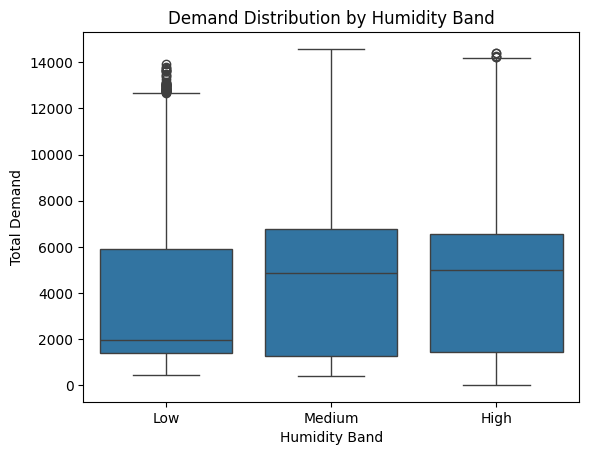

In [28]:
data["Humidity Band"] = pd.cut(
    data["Humidity (%)"],
    bins=[0, 33, 67, 100],
    labels=["Low", "Medium", "High"],
    include_lowest=True
)

sns.boxplot(data=data, x="Humidity Band", y="Total Demand")
plt.title("Demand Distribution by Humidity Band")
plt.xlabel("Humidity Band")
plt.ylabel("Total Demand")
plt.show()

### Average Daily Demand vs Humidity (Humidity Bands)

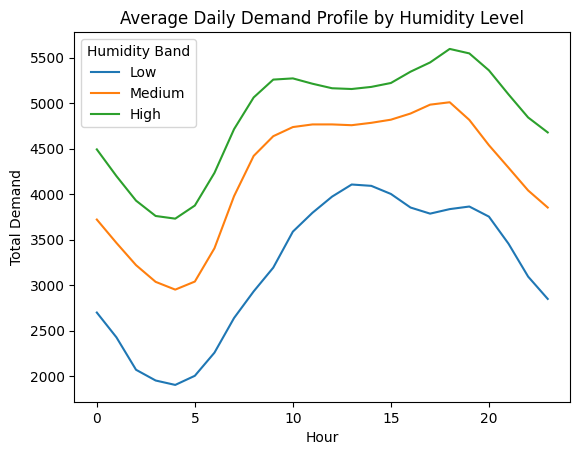

In [33]:
# Create hourly data df
data["Datetime"] = pd.to_datetime(data["Datetime"])
data["Hour"] = data["Datetime"].dt.hour
hourly = (data.groupby(["Humidity Band", "Hour"], observed=True)["Total Demand"].mean().reset_index())

sns.lineplot(data=hourly, x="Hour", y="Total Demand", hue="Humidity Band")
plt.title("Average Daily Demand Profile by Humidity Level")
plt.show()

### Seasonal Patterns

In [35]:
data["Month"] = data["Datetime"].dt.month

def get_season(month):
    # Australian seasons
    if month in [12, 1, 2]:
        return "Summer"
    elif month in [3, 4, 5]:
        return "Autumn"
    elif month in [6, 7, 8]:
        return "Winter"
    else:
        return "Spring"

data["Season"] = data["Month"].apply(get_season)

### Demand By Season

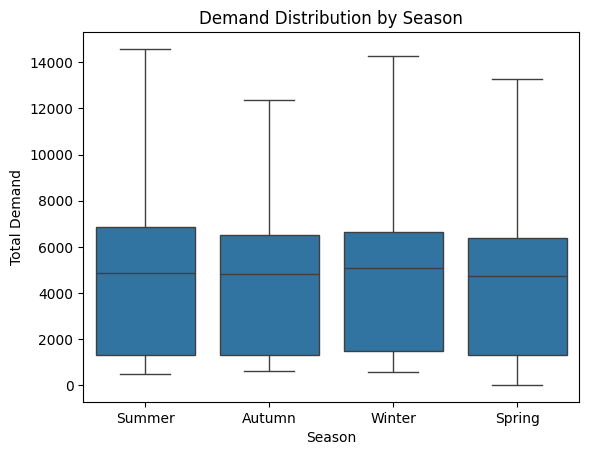

In [41]:
sns.boxplot(data=data, x="Season", y="Total Demand", order=["Summer", "Autumn", "Winter", "Spring"])
plt.title("Demand Distribution by Season")
plt.xlabel("Season")
plt.ylabel("Total Demand")
plt.show()

### Humidity By Season

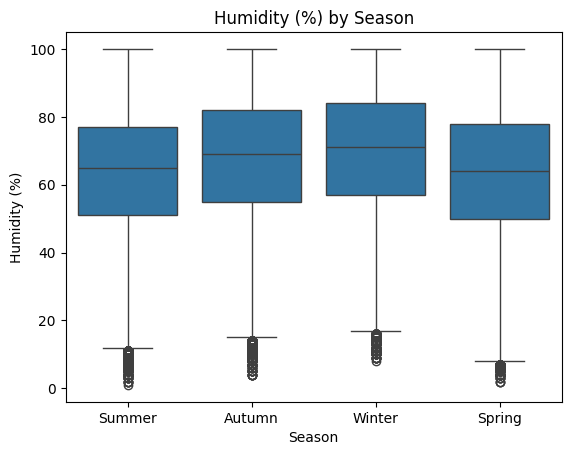

In [42]:
sns.boxplot(data=data, x="Season", y="Humidity (%)", order=["Summer", "Autumn", "Winter", "Spring"])
plt.title("Humidity (%) by Season")
plt.xlabel("Season")
plt.ylabel("Humidity (%)")
plt.show()

### Monthly Averages
Long-run average by month for both demand and humidity.

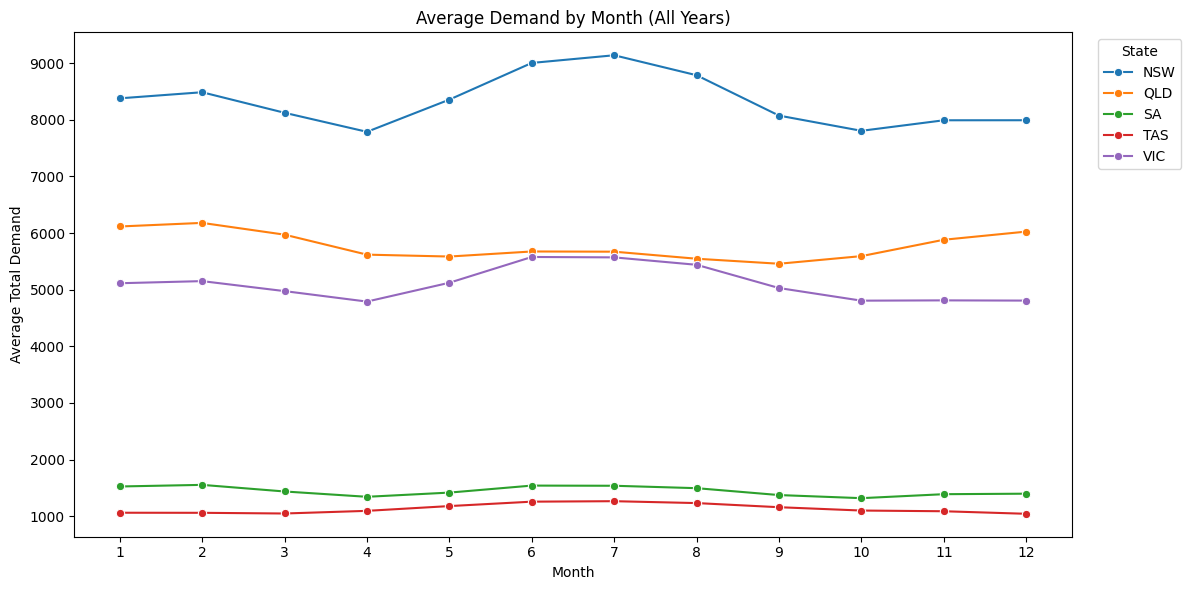

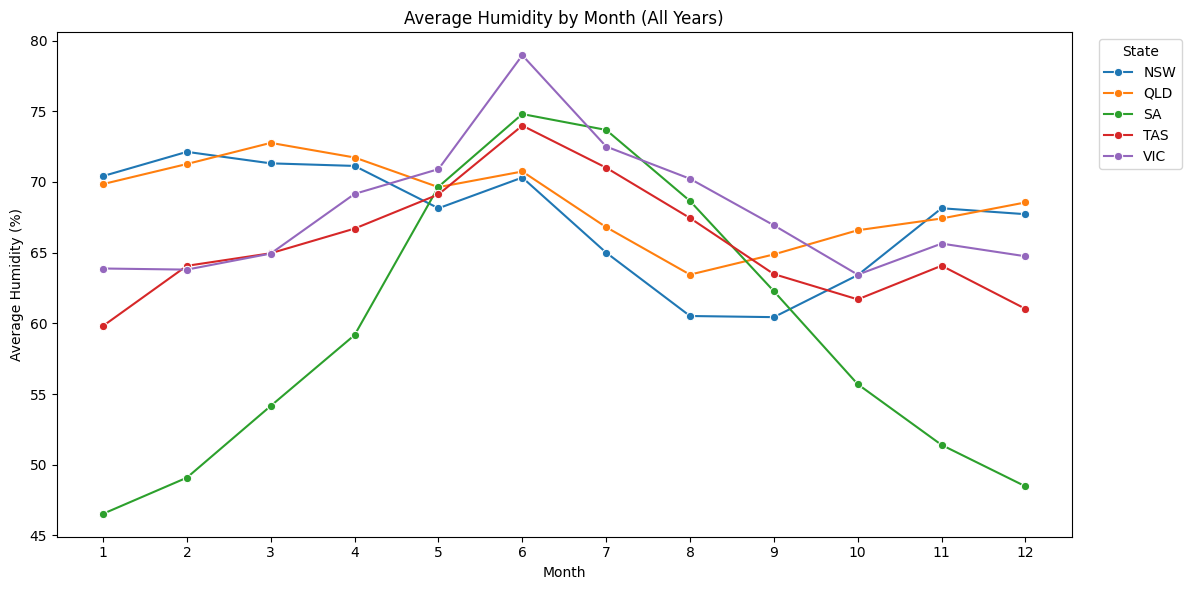

In [44]:
monthly_summary = (
    data.groupby(["State", "Month"])
        .agg(
            avg_demand=("Total Demand", "mean"),
            avg_humidity=("Humidity (%)", "mean"),
        )
        .reset_index()
)

plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_summary, x="Month", y="avg_demand", hue="State", marker="o")
plt.title("Average Demand by Month (All Years)")
plt.xlabel("Month")
plt.ylabel("Average Total Demand")
plt.xticks(range(1, 13))
plt.legend(title="State", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_summary, x="Month", y="avg_humidity", hue="State", marker="o")
plt.title("Average Humidity by Month (All Years)")
plt.xlabel("Month")
plt.ylabel("Average Humidity (%)")
plt.xticks(range(1, 13))
plt.legend(title="State", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

## Key Observations from Exploratory Analysis
- Humidity levels vary substantially across states and seasons, indicating strong geographic and climatic heterogeneity.
- Electricity demand exhibits clear seasonal patterns, with higher demand observed during periods associated with thermal discomfort.
- Scatter plots show a weak direct relationship between humidity and demand when humidity is considered in isolation.
- Grouping humidity into bands (low, medium, high) reveals modest shifts in demand distributions, suggesting humidity may influence demand indirectly rather than acting as a primary driver.
- Seasonal and monthly summaries highlight that both humidity and demand are strongly time-dependent, reinforcing the importance of accounting for weather context in modelling.

## 6. Regression Analysis
To quantify the relationship between humidity and electricity demand, fit a simple linear regression model using humidity as the primary predictor.  
State indicators are included to account for baseline differences between regions.

This analysis is exploratory and does not imply causation.

### Model Specification

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

# Clean subset
df = data.dropna(
    subset=["Humidity (%)", "Temperature", "Total Demand", "State"]
).copy()

# Quadratic + interaction terms
df["Temperature_sq"] = df["Temperature"] ** 2
df["Humidity_Temp"] = df["Humidity (%)"] * df["Temperature"]

# Build regression matrix
X = df[[
    "Humidity (%)",
    "Temperature",
    "Temperature_sq",
    "Humidity_Temp",
    "State"
]]

X = pd.get_dummies(X, columns=["State"], drop_first=True)
y = df["Total Demand"]

# Train model
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("R²:", round(r2_score(y_test, y_pred), 3))
print("MAE:", round(mean_absolute_error(y_test, y_pred), 2))

R²: 0.922
MAE: 578.99


### Regression Results

In [64]:
# Coefficients for interpretation
coefficients = pd.Series(model.coef_, index=X.columns)
coefficients.sort_values(key=abs, ascending=False)

State_TAS        -7246.590456
State_SA         -6903.712426
State_VIC        -3181.519348
State_QLD        -2658.253342
Temperature       -352.272449
Humidity (%)       -33.554671
Temperature_sq       7.373029
Humidity_Temp        1.622976
dtype: float64

### Marginal Effect of Humidity Across Temperature

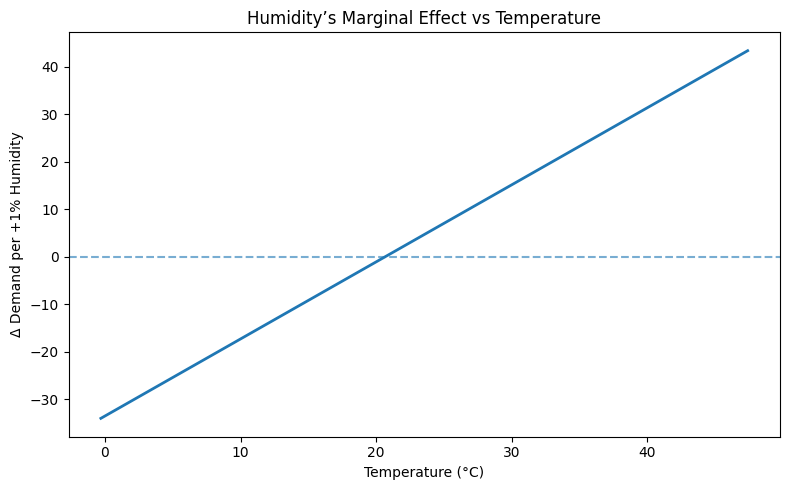

In [66]:
# Temperature range
temp_range = np.linspace(
    df["Temperature"].min(),
    df["Temperature"].max(),
    100
)

beta_h = coefficients["Humidity (%)"]
beta_ht = coefficients["Humidity_Temp"]

marginal_effect = beta_h + beta_ht * temp_range

plt.figure(figsize=(8, 5))
plt.plot(temp_range, marginal_effect, linewidth=2)
plt.axhline(0, linestyle="--", alpha=0.6)

plt.xlabel("Temperature (°C)")
plt.ylabel("Δ Demand per +1% Humidity")
plt.title("Humidity’s Marginal Effect vs Temperature")

plt.tight_layout()
plt.show()

## Key Observations from Regression Analysis
- Including temperature and its quadratic term substantially improves model fit, confirming that temperature drives the majority of explainable variation in electricity demand.
- The standalone effect of humidity is relatively small compared to temperature-related terms, indicating that humidity alone is not a dominant predictor of demand.
- The interaction between humidity and temperature reveals that the effect of humidity is **temperature-dependent** rather than constant.
- Marginal-effect analysis shows that humidity has a near-zero impact on demand at lower temperatures.
- At higher temperatures, increased humidity significantly amplifies electricity demand, consistent with reduced cooling efficiency and increased thermal discomfort.
- State fixed effects capture large baseline differences in demand across regions, reflecting structural and demographic differences between states.

## Conclusion
- This project examined the relationship between humidity and electricity demand using long-term demand and weather data across Australian states.
- Exploratory analysis shows that humidity alone has a weak direct association with electricity demand.
- Regression results demonstrate that temperature is the primary driver of demand variability, with strong non-linear effects.
- When modelled jointly with temperature, humidity exhibits a meaningful **conditional effect**, amplifying demand at higher temperatures.
- Marginal-effect analysis highlights that humidity’s impact is minimal under mild conditions but becomes increasingly important during hot weather.
- These findings underscore the importance of appropriate model specification, particularly the inclusion of non-linear and interaction terms, when analysing weather–demand relationships.
- Overall, the analysis illustrates a complete data workflow, from data processing and exploratory analysis to interpretable modelling and robust conclusions.